# Log 

* Written by YongGi Hong/ email : yghong@medicalip.com
* Written date : 20230209
---

## Code desc
* Projection data
* Padding
* Upsampling
* Function - Joseph

---


# 1. Package Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
from math import floor,ceil
import os, glob, shutil
import nibabel as nib
import cv2 as cv
import warnings
warnings.filterwarnings("ignore")

# 2. Utils function - Joseph function

In [2]:
def resize_keep_ratio(img, target_size):
    ''' 
    Resize image to target size ratio
    
    Args:
        :param img: PIL image
        :param target_size: target size
    Returns:
        :return: resize PIL image
    
    '''
    
    old_size = img.size  # old_size[0] is in (width, height) format

    ratio = float(target_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    # im.thumbnail(new_size, Image.ANTIALIAS)
    try:
        im = img.resize(new_size, Image.LANCZOS)
    except:
        im = img.resize(new_size, Image.NEAREST)
    return im


def pad_image(img, target_size, pad_value=-1024):
    ''' 
    Pad image to target size
    
    Args:
        :param img: PIL image
        :param target_size: target size
        :param pad_value: pad value
    Returns:
        :return: PIL image
    
    '''
    
    old_size = img.size
    pad_size_w = (target_size - old_size[0]) / 2
    pad_size_h = (target_size - old_size[1]) / 2

    if pad_size_w % 2 == 0:
        wl, wr = int(pad_size_w), int(pad_size_w)
    else:
        wl = ceil(pad_size_w)
        wr = floor(pad_size_w)

    if pad_size_h % 2 == 0:
        ht, hb = int(pad_size_h), int(pad_size_h)
    else:
        ht = ceil(pad_size_h)
        hb = floor(pad_size_h)

    return transforms.Compose(
        [
            transforms.Pad((wl, ht, wr, hb), fill=pad_value),
            # transforms.Pad((wl, ht, wr, hb), fill=np.min(img)),
            ]
        )
 
 
def load_nii(path):
    ''' 
    load nii.gz file
    
    Args:
        :param path: path of nii.gz file
    
    Returns:
        :return: numpy array, affine matrix, header
    
    
    '''
    
    nii = nib.load(path)
    affine = nii.affine
    header = nii.header
    arr = nii.get_fdata()
    return arr, affine, header



def save_nii(arr, affine, header=None, path, resize=False, resize_size = 2048):
    ''' 
    Save nii.gz file, if resize is True, resize image to resize_size
    
    Args:
        :param arr: numpy array
        :param affine: affine matrix
        :param header: header
        :param path: path of save file
        :param resize: resize or not
        :param resize_size: resize size
        
    Returns:
        :return: None
    
    '''
    nii = nib.Nifti1Image(np.transpose(arr.astype(np.int16), axes=[1, 0]), affine=affine, header=header)
    nib.save(nii, path)

    if resize :
        resize = Image.fromarray(arr)
        resize = resize_keep_ratio(resize, resize_size)
        img_pad = pad_image(resize, resize_size)
        resize = np.array(img_pad(resize))
        nii = nib.Nifti1Image(np.transpose(resize.astype(np.int16), axes=[1, 0]), affine=None)
        nib.save(nii, path)
    
def projection(target_dir, save_dir):
    '''
    3D CT image to 2D CT image by projection (projection axis: coronal)
    
    Args:
        :param target_dir: path of nii.gz file dir
        :param save_dir: path of save dir

    Returns:
        :return: None
    
    '''
    
    nii_paths = glob.glob(target_dir + '/*.nii.gz')
    nii_paths.sort()
    
    for idx, nii_path in enumerate(nii_paths):
        
        file_name           = os.path.basename(nii_path)
        save_path           = os.path.join(save_dir, file_name) 
        arr, affine, header = load_nii(nii_path)
        CT_Image            = np.transpose(arr, axes=[2,1,0])
        CT_Image            = np.where(CT_Image < -1024, -1024, CT_Image)
        coronal_projection3d = np.transpose(CT_Image, axes=[0, 2, 1])
        coronal_projection = np.mean(coronal_projection3d, axis=2)
        save_nii(coronal_projection, affine, header=None, save_path, 
                 resize=True, resize_size=512)   

---
# 3. Variables

In [3]:
target_dirs  = glob.glob('./data/3D*/')
target_dirs.sort()

save_dirs    = glob.glob('./data/2D*/')
save_dirs.sort()

print(target_dirs[0])
print(save_dirs[0])


./data/3D_AVF/
./data/2D_AVF/


In [4]:
for idx, target_dir in tqdm(enumerate(target_dirs)):
    projection(target_dir, save_dirs[idx])

10it [00:23,  2.36s/it]


---

# 4. Data check

In [57]:
CT_paths     = glob.glob('./data/2D_CT/*.nii.gz')
Bone_paths   = glob.glob('./data/2D_Bone/*.nii.gz')
Skin_paths   = glob.glob('./data/2D_Skin/*.nii.gz')
Muscle_paths = glob.glob('./data/2D_Muscle/*.nii.gz')
AVF_paths    = glob.glob('./data/2D_AVF/*.nii.gz')
OF_paths     = glob.glob('./data/2D_OF(SF)/*.nii.gz')
IO_paths     = glob.glob('./data/2D_IO/*.nii.gz')
BSC_paths    = glob.glob('./data/2D_BSC(CNS)/*.nii.gz')
whole_body_paths = glob.glob('./data/2D_whole_body/*.nii.gz')
Mask_paths   = glob.glob('./data/2D_Mask/*.nii.gz')

In [58]:
Skin   =  nib.load(Skin_paths[0]).get_fdata()
Bone   =  nib.load(Bone_paths[0]).get_fdata()
Muscle =  nib.load(Muscle_paths[0]).get_fdata()
AVF    =  nib.load(AVF_paths[0]).get_fdata()
OF     =  nib.load(OF_paths[0]).get_fdata()
IO     =  nib.load(IO_paths[0]).get_fdata()
BSC    =  nib.load(BSC_paths[0]).get_fdata()
whole_body = nib.load(whole_body_paths[0]).get_fdata()
CT     =  nib.load(CT_paths[0]).get_fdata()

In [59]:
print("whole_body ")
print(whole_body.shape)
print(whole_body.min())
print(whole_body.max())

whole_body 
(512, 512)
-1024.0
138.0


In [60]:
total = Skin + Bone + Muscle + AVF + OF + IO + BSC

In [61]:
print("Total ")
print(total.shape)
print(total.min())
print(total.max())

Total 
(512, 512)
-7168.0
139.0


In [62]:
diff = whole_body - total

In [71]:
print("differece map")
print("range : ", diff[:,100:400].min(), diff[:,100:400].max())

differece map
range :  -4.0 4.0


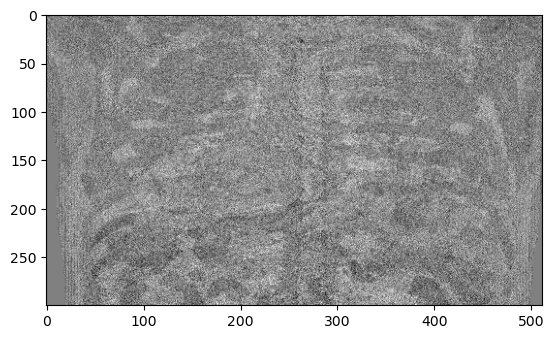

In [72]:
plt.imshow(np.rot90(diff[:,100:400],3), cmap='gray')